## Lesson-01

In [1]:
from sklearn.datasets import load_boston

In [2]:
data = load_boston()

In [3]:
import pandas as pd

In [4]:
dataframe = pd.DataFrame(data['data'])

In [5]:
dataframe.columns = data['feature_names']

In [6]:
dataframe['price'] = data['target']

In [7]:
import seaborn as sns

In [8]:
%matplotlib inline

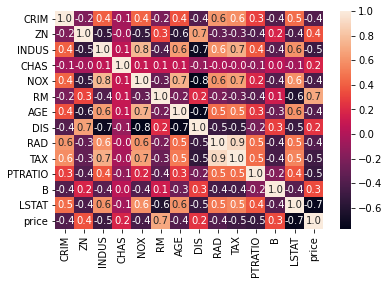

In [9]:
sns.heatmap(dataframe.corr(), annot=True, fmt='.1f')

In [11]:
import matplotlib.pyplot as plt

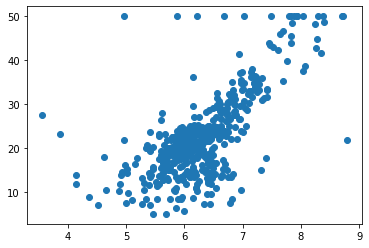

In [12]:
plt.scatter(dataframe['RM'], dataframe['price'])

In [13]:
x = dataframe['RM']

In [14]:
y = dataframe['price']

In [15]:
history_notes = {_x : _y for _x, _y in zip(x, y)}

In [26]:
history_notes[6.575]

24.0

In [27]:
similary_ys = [y for _, y in sorted(history_notes.items(), key=lambda x_y: (x_y[0] - 6.57) ** 2)[:3]]

In [30]:
def find_price_by_similar(history_price,query_x,topn=3):
    return np.mean([p for x,p in sorted(history_price.items(), key=lambda e:(e[0]-query_x)**2)[:topn]])

In [31]:
person_and_age = {
    'A周杰伦':40,
    'C刘德华':60,
    'B蔡徐坤':25
}

In [33]:
np.mean([age for name,age in sorted(person_and_age.items(), key=lambda e:e[1])[:2]])

32.5

In [28]:
import numpy as np

In [29]:
np.mean(similary_ys)

24.2

## 用历史数据来预测未曾见到的过的数据，最直接的方法

## K-Neighbor-Nearst

In [19]:
def knn(query_x, history, top_n=3):
    sorted_notes = sorted(history.items(), key=lambda x_y: (x_y[0] - query_x) ** 2) 
    similar_notes = sorted_notes[:top_n]
    similar_ys = [y for _, y in similar_notes]
    
    return np.mean(similar_ys)

In [20]:
knn(5.4, history_notes)

15.700000000000001

## 为了更快的获得结果，我们希望通过拟合函数来获得预测能力

$$ f(rm) = k * rm + b $$ 

## Random Approach

$$ Loss(k, b) = \frac{1}{n} \sum_{i \in N} (\hat{y_i} - y_i) ^ 2 $$
$$ Loss(k, b) = \frac{1}{n} \sum_{i \in N} ((k * rm_i + b) - y_i) ^ 2 $$

In [37]:
def loss(y_hat, y):
    return np.mean((y_hat - y) ** 2)

In [38]:
import random

In [39]:
min_loss = float('inf') # 最小loss定义为无穷
best_k, best_b = None, None # 保存 最好的参数 k和b

k_b_history = [] # 记录最好参数历史

for step in range(1000):
    min_v, max_v = -100, 100
    k, b = random.randrange(min_v, max_v), random.randrange(min_v, max_v) # 随机k和b
    y_hats = [k * rm_i  + b for rm_i in x]
    current_loss = loss(y_hats, y) # 计算loss
    
    if current_loss < min_loss: # 保留最小的loss的参数
        min_loss = current_loss
        best_k, best_b = k, b
        k_b_history.append([best_k,best_b])
        print('在第{}步，我们获得了函数 f(rm) = {} * rm + {}, 此时loss是: {}'.format(step, k, b, current_loss))

在第0步，我们获得了函数 f(rm) = -65 * rm + 3, 此时loss是: 185962.1910505435
在第1步，我们获得了函数 f(rm) = 50 * rm + -100, 此时loss是: 37616.17430335969
在第4步，我们获得了函数 f(rm) = -7 * rm + 35, 此时loss是: 1165.186740124506
在第65步，我们获得了函数 f(rm) = 21 * rm + -97, 此时loss是: 268.21236704940713
在第85步，我们获得了函数 f(rm) = -9 * rm + 86, 此时loss是: 252.7357604881423
在第167步，我们获得了函数 f(rm) = -7 * rm + 66, 此时loss是: 171.6214239189723
在第233步，我们获得了函数 f(rm) = 9 * rm + -25, 此时loss是: 125.12678104150199
在第288步，我们获得了函数 f(rm) = 17 * rm + -82, 此时loss是: 79.65078059881422
在第289步，我们获得了函数 f(rm) = 4 * rm + -5, 此时loss是: 62.15867816600791


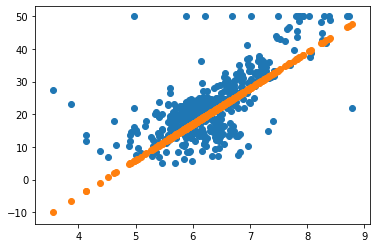

In [24]:
plt.scatter(x, y)
plt.scatter(x, [best_k * rm + best_b for rm in x])

## 蒙特卡洛模拟

## Supervisor

$$ Loss(k, b) = \frac{1}{n} \sum_{i \in N} ((k * rm_i + b) - y_i) ^ 2 $$

$$ \frac{\partial{loss(k, b)}}{\partial{k}} = \frac{2}{n}\sum_{i \in N}(k * rm_i + b - y_i) * rm_i $$

$$ \frac{\partial{loss(k, b)}}{\partial{b}} = \frac{2}{n}\sum_{i \in N}(k * rm_i + b - y_i)$$

In [40]:
def partial_k(k, b, x, y):
    return 2 * np.mean((k * x + b - y) * x)

def partial_b(k, b, x, y):
    return 2 * np.mean(k * x + b - y)

k, b = random.random(), random.random()
min_loss = float('inf')
best_k, bes_b = None, None
learning_rate = 1e-2
k_b_history = []

for step in range(2000):
    k, b = k + (-1 * partial_k(k, b, x, y) * learning_rate), b + (-1 * partial_b(k, b, x, y) * learning_rate) # 梯度方向更新k和b
    y_hats = k * x + b # 当前预测值
    current_loss = loss(y_hats, y) # 计算损失
    
    if current_loss < min_loss: # 保留最好的结果
        min_loss = current_loss
        best_k, best_b = k, b
        k_b_history.append([best_k,best_b])
        print('在第{}步，我们获得了函数 f(rm) = {} * rm + {}, 此时loss是: {}'.format(step, k, b, current_loss))

在第0步，我们获得了函数 f(rm) = 3.013974904795109 * rm + 0.4797528194631926, 此时loss是: 71.54281737406791
在第1步，我们获得了函数 f(rm) = 3.465037367847182 * rm + 0.5419792829703293, 此时loss是: 59.302658018695624
在第2步，我们获得了函数 f(rm) = 3.547524754465451 * rm + 0.5462659638845102, 此时loss是: 58.89696051376461
在第3步，我们获得了函数 f(rm) = 3.5635010390623854 * rm + 0.5400988498511284, 此时loss是: 58.876639573035774
在第4步，我们获得了函数 f(rm) = 3.5674748681852213 * rm + 0.5320469759472142, 此时loss是: 58.868871314705395
在第5步，我们获得了函数 f(rm) = 3.5692825441265743 * rm + 0.5236566582582814, 此时loss是: 58.861515234831096
在第6步，我们获得了函数 f(rm) = 3.570699066849536 * rm + 0.515206935275483, 此时loss是: 58.85417599278179
在第7步，我们获得了函数 f(rm) = 3.572044742225521 * rm + 0.5067481602040368, 此时loss是: 58.846840713185294
在第8步，我们获得了函数 f(rm) = 3.573377370786986 * rm + 0.4982894190791769, 此时loss是: 58.839508975130784
在第9步，我们获得了函数 f(rm) = 3.5747073829331093 * rm + 0.4898323511111552, 此时loss是: 58.83218076327087
在第10步，我们获得了函数 f(rm) = 3.5760366609339593 * rm + 0.48137725170

In [26]:
best_k, best_b

(5.651174530380487, -12.718819491231425)

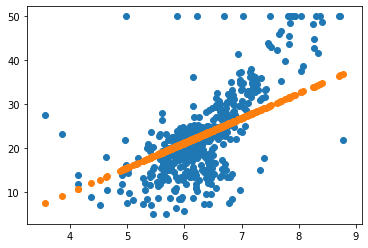

In [27]:
plt.scatter(x, y)
plt.scatter(x, [best_k * rm + best_b for rm in x])

## Supervised Learning

## 我们把房价的预测 变成更加负责，精细的模型，该怎么做？

$$ f(x) = k * x + b $$

$$ f(x) = k2 * \sigma(k_1 * x + b_1) + b2 $$

$$ \sigma(x) = \frac{1}{1 + e^(-x)} $$ 

In [28]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

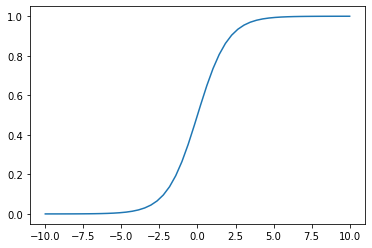

In [29]:
sub_x = np.linspace(-10, 10)
plt.plot(sub_x, sigmoid(sub_x))

In [30]:
def random_linear(x):
    k, b = random.random(), random.random()
    return k * x + b

In [31]:
def complex_function(x):
    return (random_linear(x))

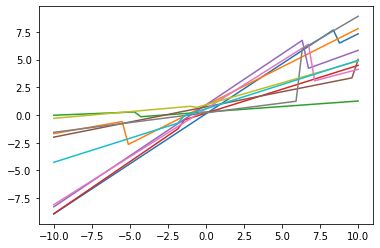

In [33]:
for _ in range(10):
    index = random.randrange(0, len(sub_x))
    sub_x_1, sub_x_2 = sub_x[:index], sub_x[index:]
    new_y = np.concatenate((complex_function(sub_x_1), complex_function(sub_x_2)))
    plt.plot(sub_x, new_y)

## 我们可以通过简单的、基本的模块，经过反复的叠加，来实现更加复杂的函数

## 面向越来越越复杂的函数？计算机如何求导？

## 1. 什么是机器学习？
## 2. KNN这种方法的缺陷，提出线性拟合的背景是什么
## 3. 怎么样通过监督的方法，来获得更快的函数权值更新
## 4. 非线性函数和线性函数的结合，可以拟合出非常复杂的函数
## 5. 深度学习我们可以通过基本的函数模块，来拟合更加复杂的函数

## Assigment:

$$ L2-Loss(y, \hat{y}) = \frac{1}{n}\sum{(\hat{y} - y)}^2 $$
$$ L1-Loss(y, \hat{y}) = \frac{1}{n}\sum{|(\hat{y} - y)|} $$


## 将课堂代码中的L2-Loss 变成L1Loss 并且实现梯度下降